# A Physics-Informed Neural Network approach for compartmental epidemiological models


Notebooks for PINN solution of the SIR compartmental model presented [in the paper](https://arxiv.org/abs/2311.09944):

```
@misc{millevoi2023physicsinformed,
      title={A Physics-Informed Neural Network approach for compartmental epidemiological models}, 
      author={Caterina Millevoi and Damiano Pasetto and Massimiliano Ferronato},
      year={2023},
      eprint={2311.09944},
      archivePrefix={arXiv},
      primaryClass={math.NA}
}
```

Note: The uploaded code is related to Case 2. For further information please contact the corresponding author.

In [1]:
import sciann as sn
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

2024-06-05 11:19:39.244729: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-05 11:19:39.244825: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


---------------------- SCIANN 0.6.6.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.5.3 
Python Version: 3.8.10 (default, Nov 22 2023, 10:22:35) 
[GCC 9.4.0] 

Outdated SciANN installation is found (V-0.6.6.1). Get the latest version (V-0.7.0.1):  
      > pip [--user] install --upgrade sciann  


## Case 2: Synthetic transmission rate

In [2]:
# SIR parameters
N     = 56e6 # (-) population (Italy)
delta = 1/5  # (1/T) 5 = mean reproduction period 

t0   = 0.       # (days) initial time
tf = 90.        # (days) final time

C = 1e5
C1 = tf*C/N   
C2 = tf*delta

In [3]:
# Initial conditions
S0 = N-1
I0 = 1
R0 = 0

In [4]:
df_SIR = pd.read_table("./SIR_rt.txt")
df_SIR

,time,Susceptible,Infectious,Recovered,I data,Rt
0,737822,56000000.0,1.000000,0.000000,2.0,2.999096
1,737823,56000000.0,1.491561,0.245897,1.0,2.999012
2,737824,56000000.0,2.224673,0.612644,2.0,2.998901
3,737825,56000000.0,3.318304,1.159787,4.0,2.998708
4,737826,55999990.0,4.948500,1.975481,6.0,2.998346
...,...,...,...,...,...,...
85,737907,55106450.0,132885.300000,760662.200000,132364.0,1.298702
86,737908,55074620.0,137564.300000,787817.600000,137824.0,1.081675
87,737909,55048070.0,136592.900000,815336.300000,137152.0,0.881484
88,737910,55027210.0,130653.200000,842133.100000,129965.0,0.705160


In [5]:
t_data = np.arange(t0,tf)
t_test = np.arange(t0,tf,0.1)


S_data = df_SIR["Susceptible"].values
I_data = df_SIR["Infectious"].values
R_data = df_SIR["Recovered"].values
I_obs  = df_SIR["I data"].values
Rt_data = df_SIR["Rt"].values
beta_data = Rt_data*delta

I_obs_sc  = I_obs/C
I_data_sc = I_data/C
t_data_sc = t_data/tf
t_test_sc = t_test/tf

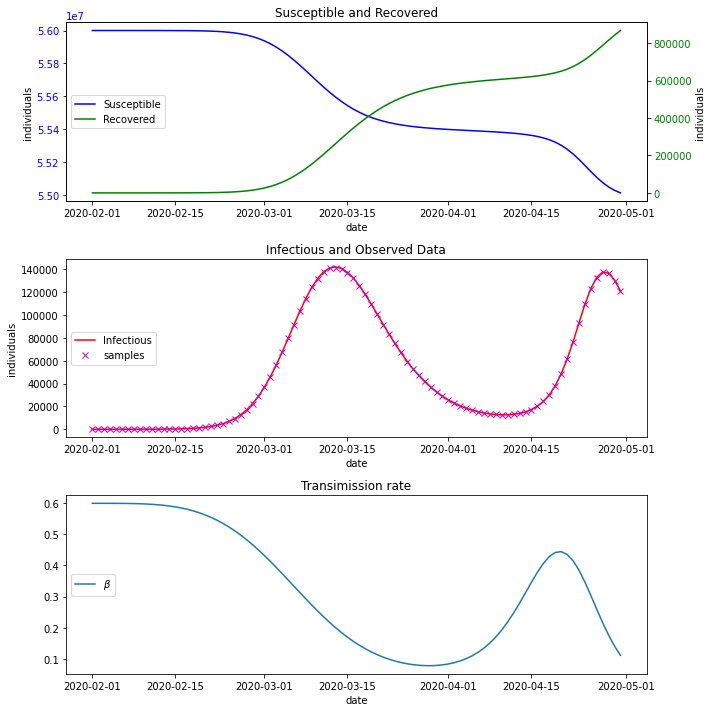

In [6]:
timespan = np.arange('2020-02-01', '2020-05-01', dtype='datetime64[D]')

# Plot results
fig, ax = plt.subplots(3, 1, figsize=(10,10))
plotS = ax[0].plot(timespan, S_data, 'b', label='Susceptible')
ax[0].tick_params(axis='y', labelcolor='b')
# ax[0].legend()
ax[0].set_xlabel('date')
ax[0].set_ylabel('individuals')
ax[0].set_title('Susceptible and Recovered')

ax2 = ax[0].twinx()

plotR = ax2.plot(timespan, R_data, 'g', label='Recovered')
ax2.set_ylabel('individuals')
ax2.tick_params(axis='y', labelcolor='g')

lplot = plotS+plotR
ax[0].legend(lplot,[l.get_label() for l in lplot], loc=6)

ax[1].plot(timespan, I_data, 'r', label='Infectious')
ax[1].plot(timespan, I_obs, 'xm', label='samples')
ax[1].legend(loc=6)
ax[1].set_xlabel('date')
ax[1].set_ylabel('individuals')
ax[1].set_title('Infectious and Observed Data')

ax[2].plot(timespan,beta_data, label=r"$\beta$")
ax[2].legend(loc=6)
ax[2].set_xlabel('date')
ax[2].set_title('Transimission rate')

fig.tight_layout()

plt.show()

In [7]:
# Training parameters
loss_err  = 'mse'
optimizer = 'adam'
adaptive_NTK = {'method':'NTK','freq':100}

### Joint

In [8]:
sn.reset_session()

In [9]:
# Build NN - Joint
ts  = sn.Variable("ts")
Ss = sn.Functional("Ss", ts, 4*[50], output_activation='square')
Is = sn.Functional("Is", ts, 4*[50], output_activation='square')

Beta = sn.Functional("Beta", ts, 4*[100], output_activation='square')

Rs = N/C-Is-Ss

In [10]:
# Initial Conditions
L_S0 = sn.rename((Ss-S0/C)*(1-sn.sign(ts-t0/tf)), "L_S0")
L_I0 = sn.rename((Is-I0/C)*(1-sn.sign(ts-t0/tf)), "L_I0")
L_R0 = sn.rename((Rs-R0/C)*(1-sn.sign(ts-t0/tf)), "L_R0")

# ODEs
L_dSdt = sn.rename((sn.diff(Ss,ts)+C1*Beta*Is*Ss), "L_dSdt")
L_dIdt = sn.rename((sn.diff(Is,ts)-C1*Beta*Is*Ss+C2*Is), "L_dIdt")
L_dRdt = sn.rename((sn.diff(Rs,ts)-C2*Is), "L_dRdt")

In [11]:
loss_joint = [sn.PDE(L_dSdt),  sn.PDE(L_dIdt),  sn.PDE(L_dRdt), 
              sn.PDE(L_S0),    sn.PDE(L_I0),    sn.PDE(L_R0),
              sn.Data(Ss*0.0), sn.Data(Rs*0.0), sn.Data(Beta*0.0),
              sn.Data(Is)]

In [12]:
m = sn.SciModel(ts, loss_joint, loss_err, optimizer)

In [13]:
# Training points
Nc = 6000    # collocation points

I_obs_sc = I_obs_sc.reshape(-1,1)
t_train_ode = np.random.uniform(t0/tf, 1., Nc-1)
t_train_ode = np.insert(t_train_ode,0,0.0)
t_train = np.concatenate([t_data_sc.reshape(-1,1), t_train_ode.reshape(-1,1)])
ids_data = np.arange(t_data_sc.size, dtype=np.intp)

In [14]:
loss_train   = ['zeros']*9+[(ids_data,I_obs_sc)]
epochs_joint = 5000
batch_size   = 100

In [ ]:
# Train the model
time1 = time.time()
h     = m.train(t_train,
                loss_train,
                epochs=epochs_joint,
                batch_size=batch_size,
                adaptive_weights=adaptive_NTK,
                verbose=1
               )
time2 = time.time()

In [16]:
print(f'Training time: {time2-time1}')

Training time: 2002.66689991951


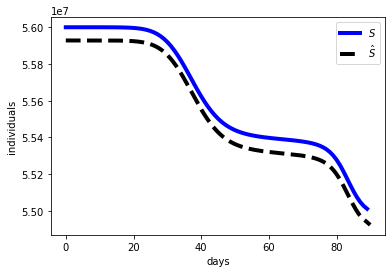

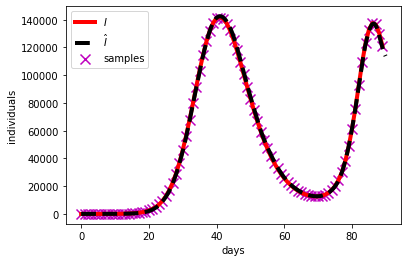

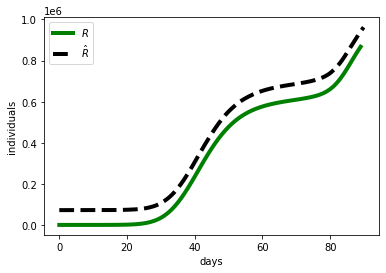

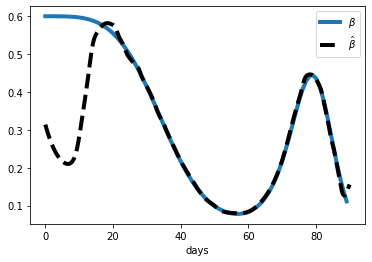

In [17]:
# Get predictions
S_pred_test = Ss.eval(m, t_test_sc)*C
I_pred_test = Is.eval(m, t_test_sc)*C
R_pred_test = Rs.eval(m, t_test_sc)*C
beta_pred_test = Beta.eval(m, t_test_sc)

# Plot results
plt.plot(t_data, S_data, c='b',linewidth=4)
plt.plot(t_test,S_pred_test, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend([r'$S$', r'$\hat{S}$'])
plt.show()

plt.plot(t_data,I_data, c='r', linewidth=4)
plt.plot(t_test,I_pred_test, '--', c='k', linewidth=4)
plt.scatter(t_data,I_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend([r'$I$',r'$\hat{I}$','samples'])
plt.show()

plt.plot(t_data, R_data, c='g',linewidth=4)
plt.plot(t_test,R_pred_test, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend([r'$R$', r'$\hat{R}$'])
plt.show()

plt.plot(t_data, beta_data, linewidth=4)
plt.plot(t_test, beta_pred_test, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.legend([r'$\beta$', r'$\hat{\beta}$'])
plt.show()


In [18]:
# Evaluate errors
S_pred = Ss.eval(m, t_data_sc)*C
I_pred = Is.eval(m, t_data_sc)*C
R_pred = Rs.eval(m, t_data_sc)*C
beta_pred = Beta.eval(m, t_data_sc)

S_err = np.linalg.norm(S_data-S_pred,2)/np.linalg.norm(S_data,2)
I_err = np.linalg.norm(I_data-I_pred,2)/np.linalg.norm(I_data,2)
R_err = np.linalg.norm(R_data-R_pred,2)/np.linalg.norm(R_data,2)
beta_err = np.linalg.norm(beta_data-beta_pred,2)/np.linalg.norm(beta_data,2)

print(f'S error: {S_err:.3e}')
print(f'I error: {I_err:.3e}')
print(f'R error: {R_err:.3e}')
print(f'Beta error: {beta_err:.3e}')

S error: 1.334e-03
I error: 1.079e-02
R error: 1.682e-01
Beta error: 3.380e-01


### Split

In [19]:
sn.reset_session()

In [20]:
# Build NN - Split - only data regression
ts  = sn.Variable("ts")
Isc = sn.Functional("Isc", ts, 4*[50], output_activation='square')

In [21]:
# Build the model - Split - only data regression
loss_data = sn.Data(Isc)

m_data = sn.SciModel(ts, loss_data, loss_err, optimizer)

In [22]:
t_data_train = t_data_sc
epochs_data  = 3000
batch_data   = 10

In [ ]:
# Train the model - Split - only data regression
time1_data = time.time()
h_data     = m_data.train(t_data_train, 
                          I_obs_sc, 
                          epochs=epochs_data,
                          batch_size=batch_data,
                          verbose=1)
time2_data = time.time()

In [24]:
print(f'Training time: {time2_data-time1_data}')

Training time: 311.6409447193146


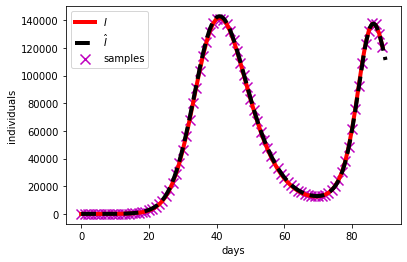

In [25]:
# Get predictions
Isc_pred = Isc.eval(m_data, t_test_sc)

# Plot results
plt.plot(t_data,I_data, c='r', linewidth=4)
plt.plot(t_test,Isc_pred*C, '--', c='k', linewidth=4)
plt.scatter(t_data,I_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend(['$I$','$\hat{I}$','samples'])
plt.show()

In [26]:
# Evaluate errors
Isc_pred = Isc.eval(m_data,t_data_sc)
Isc_err = np.linalg.norm(I_data_sc-Isc_pred,2)/np.linalg.norm(I_data_sc,2)
print(f'Isc error: {Isc_err:.3e}')

Isc error: 1.027e-02


In [27]:
# Fix the I-NN weights
Isc_weights = Isc.get_weights()

Is = sn.Functional("Is", ts, 4*[50], output_activation='square', trainable=False)
Is.set_weights(Isc_weights)

In [28]:
# Build NN - Split - fully physics-informed
Ss = sn.Functional("Ss", ts, 4*[50], output_activation='square')

Beta = sn.Functional("Beta", ts, 4*[100], output_activation='square')

Rs = N/C-Is-Ss

In [29]:
# Initial Conditions
L_S0 = sn.rename((Ss-S0/C)*(1-sn.sign(ts-t0/tf)), "L_S0")
L_R0 = sn.rename((Rs-R0/C)*(1-sn.sign(ts-t0/tf)), "L_R0")

# ODEs
L_dSdt = sn.rename((sn.diff(Ss,ts)+C1*Beta*Is*Ss), "L_dSdt")
L_dIdt = sn.rename((sn.diff(Is,ts)-C1*Beta*Is*Ss+C2*Is), "L_dIdt")
L_dRdt = sn.rename((sn.diff(Rs,ts)-C2*Is), "L_dRdt")

In [30]:
# Build the model - Split - fully physics-informed
loss_ode = [sn.PDE(L_dSdt),  sn.PDE(L_dIdt),  sn.PDE(L_dRdt), 
            sn.PDE(L_S0), sn.PDE(L_R0), 
            sn.Data(Ss*0.0), sn.Data(Rs*0.0), sn.Data(Beta*0.0),
            sn.Data(Is*0.0)]

m_ode = sn.SciModel(ts, loss_ode, loss_err, optimizer)

loss_train_ode = ['zeros']*9

epochs_ode = 1000

In [ ]:
# Train the model - Split - fully physics-informed
time1_ode = time.time()
h_ode     = m_ode.train(t_train_ode,
                        loss_train_ode,
                        epochs=epochs_ode,
                        batch_size=batch_size,
                        adaptive_weights=adaptive_NTK,
                        verbose=1)
time2_ode = time.time()

In [32]:
print(f'Training time: {time2_ode-time1_ode}')

Training time: 386.45364141464233


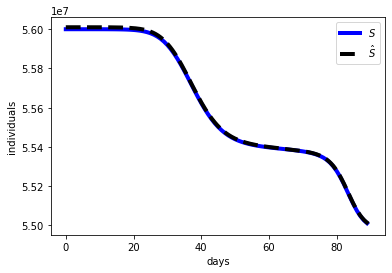

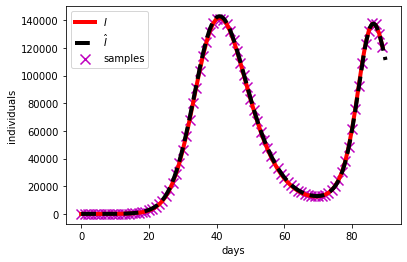

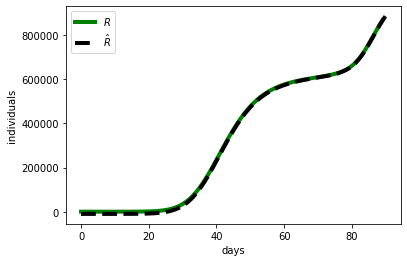

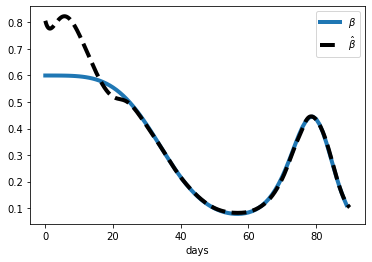

In [33]:
# Get predictions
S_pred_test = Ss.eval(m_ode, t_test_sc)*C
I_pred_test = Is.eval(m_ode, t_test_sc)*C
R_pred_test = Rs.eval(m_ode, t_test_sc)*C
beta_pred_test = Beta.eval(m_ode, t_test_sc)

# Plot results
plt.plot(t_data, S_data, c='b',linewidth=4)
plt.plot(t_test,S_pred_test, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend([r'$S$', r'$\hat{S}$'])
plt.show()

plt.plot(t_data,I_data, c='r', linewidth=4)
plt.plot(t_test,I_pred_test, '--', c='k', linewidth=4)
plt.scatter(t_data,I_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend([r'$I$',r'$\hat{I}$',r'samples'])
plt.show()

plt.plot(t_data, R_data, c='g',linewidth=4)
plt.plot(t_test,R_pred_test, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend([r'$R$', r'$\hat{R}$'])
plt.show()

plt.plot(t_data, beta_data, linewidth=4)
plt.plot(t_test, beta_pred_test, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.legend([r'$\beta$', r'$\hat{\beta}$'])
plt.show()


In [34]:
# Evaluate errors
S_pred = Ss.eval(m_ode, t_data_sc)*C
I_pred = Is.eval(m_ode, t_data_sc)*C
R_pred = Rs.eval(m_ode, t_data_sc)*C
beta_pred = Beta.eval(m_ode, t_data_sc)

S_err = np.linalg.norm(S_data-S_pred,2)/np.linalg.norm(S_data,2)
I_err = np.linalg.norm(I_data-I_pred,2)/np.linalg.norm(I_data,2)
R_err = np.linalg.norm(R_data-R_pred,2)/np.linalg.norm(R_data,2)
beta_err = np.linalg.norm(beta_data-beta_pred,2)/np.linalg.norm(beta_data,2)
beta_err70 = np.linalg.norm(beta_data[20:]-beta_pred[20:],2)/np.linalg.norm(beta_data[20:],2)

print(f'S error: {S_err:.3e}')
print(f'I error: {I_err:.3e}')
print(f'R error: {R_err:.3e}')
print(f'Beta error: {beta_err:.3e}')
print(f'Beta error last 70 days: {beta_err70:.3e}')

S error: 1.095e-04
I error: 1.027e-02
R error: 1.465e-02
Beta error: 1.898e-01
Beta error last 70 days: 2.480e-02
